© Alexander Jüstel, Fraunhofer IEG, Institution for Energy Infrastructures and Geothermal Systems, RWTH Aachen University,
GNU Lesser General Public License v3.0

# 13 Processing and merging heat demand data for NRW

This notebook illustrates how to process data for the state of North Rhine-Westphalia including processing the input data sequentially for every cell of the global mask. 

## Importing Libraries

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import rasterio
from rasterio.plot import show
import numpy as np

from pyheatdemand import processing

## Importing Outline of NRW
The outline of NRW is imported using `GeoPandas`.

In [43]:
outline_nrw = gpd.read_file('../../../data/nw_dvg1_rbz.shp')
outline_nrw

,ART,GN,KN,STAND,geometry
0,R,Arnsberg,05900000,20230612,"POLYGON ((3854043.358 2686588.658, 3854042.704..."
1,R,Detmold,05700000,20230612,"POLYGON ((3922577.630 2751867.434, 3922590.877..."
2,R,Köln,05300000,20230612,"MULTIPOLYGON (((3815551.417 2711668.010, 38155..."
3,R,Düsseldorf,05100000,20230612,"POLYGON ((3808552.027 2712730.070, 3808544.236..."
4,R,Münster,05500000,20230612,"MULTIPOLYGON (((3827457.753 2766673.130, 38274..."


In [13]:
outline_nrw.crs

<Projected CRS: EPSG:3034>
Name: ETRS89-extended / LCC Europe
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Conformal 2001
- method: Lambert Conic Conformal (2SP)
Datum: Euro

<Axes: >

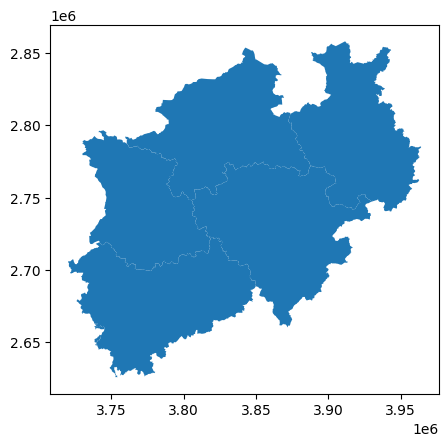

In [3]:
outline_nrw.plot()

## Loading the Global 10 km Mask
The global 10 km mask is also loaded using `GeoPandas`.

In [5]:
mask_10km = gpd.read_file('../../../data/Interreg_NWE_mask_10km_3034.shp')
mask_10km

,FID,geometry
0,0,"POLYGON ((2651470.877 2955999.353, 2651470.877..."
1,1,"POLYGON ((2651470.877 2965999.353, 2651470.877..."
2,2,"POLYGON ((2651470.877 2975999.353, 2651470.877..."
3,3,"POLYGON ((2651470.877 2985999.353, 2651470.877..."
4,4,"POLYGON ((2651470.877 2995999.353, 2651470.877..."
...,...,...
9225,9225,"POLYGON ((4141470.877 2605999.353, 4141470.877..."
9226,9226,"POLYGON ((4141470.877 2615999.353, 4141470.877..."
9227,9227,"POLYGON ((4151470.877 2585999.353, 4151470.877..."
9228,9228,"POLYGON ((4151470.877 2595999.353, 4151470.877..."


In [14]:
mask_10km.crs

<Projected CRS: EPSG:3034>
Name: ETRS89-extended / LCC Europe
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Conformal 2001
- method: Lambert Conic Conformal (2SP)
Datum: Euro

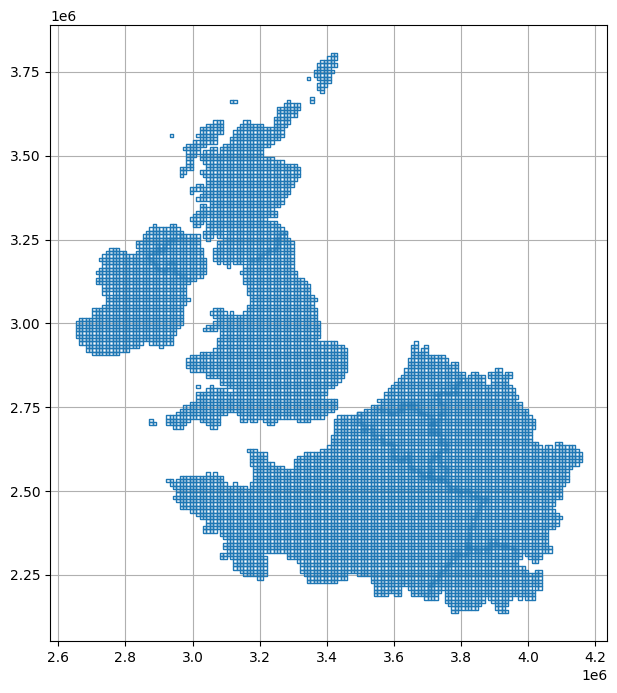

In [22]:
fig, ax = plt.subplots(1, figsize=(8,8))
mask_10km.boundary.plot(ax=ax, linewidth=1)
plt.grid()

## Crpping the global mask to the outline of NRW

The global mask will be cropped to the outline of NRW using the `sjoin` method of the `GeoPandas` package. We also drop the duplicates that were still present in the mask. 

In [55]:
mask_10km_cropped = mask_10km.sjoin(outline_nrw).reset_index(drop=True).drop('index_right', axis=1)[['geometry']]
mask_10km_cropped = mask_10km_cropped.drop_duplicates(ignore_index=True)
mask_10km_cropped

,geometry
0,"POLYGON ((3711470.877 2695999.353, 3711470.877..."
1,"POLYGON ((3721470.877 2665999.353, 3721470.877..."
2,"POLYGON ((3731470.877 2635999.353, 3731470.877..."
3,"POLYGON ((3731470.877 2645999.353, 3731470.877..."
4,"POLYGON ((3731470.877 2655999.353, 3731470.877..."
...,...
385,"POLYGON ((3951470.877 2775999.353, 3951470.877..."
386,"POLYGON ((3951470.877 2785999.353, 3951470.877..."
387,"POLYGON ((3951470.877 2795999.353, 3951470.877..."
388,"POLYGON ((3961470.877 2755999.353, 3961470.877..."


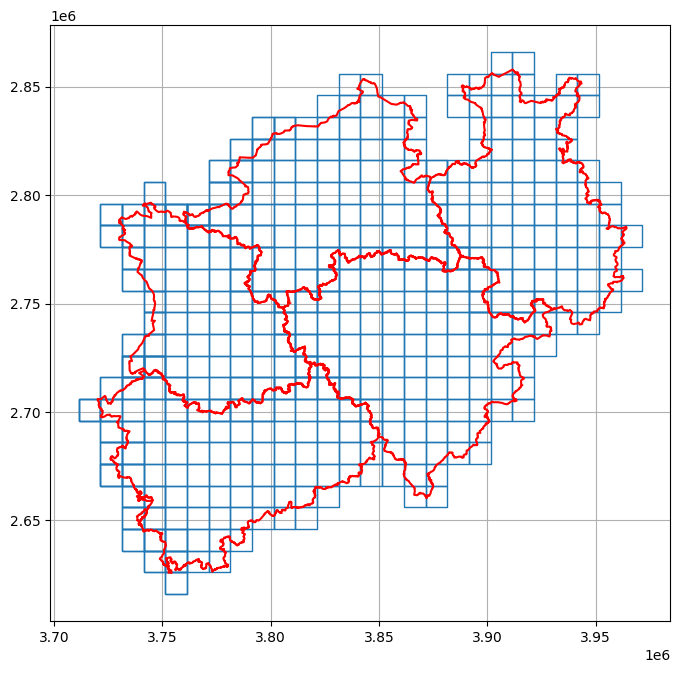

In [21]:
fig, ax = plt.subplots(1, figsize=(8,8))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=1)
outline_nrw.boundary.plot(ax=ax, color='red')
plt.grid()

## Creating local 100 m mask
Each 10 km cell will now be populated with 100 m cells. 

**NB: For the sake of demonstration, we are increasing the cell size to 500 m.**

In [ ]:
mask_100m_cropped = [processing.create_polygon_mask(gdf=mask_10km_cropped[i:i+1], 
                                                   step_size=500,
                                                   crop_gdf=True) for i in tqdm(range(len(mask_10km_cropped)))]
mask_100m_cropped

In [53]:
mask_100m = pd.concat(mask_100m_cropped)
mask_100m

,geometry
0,"POLYGON ((3711470.877 2695999.353, 3711970.877..."
1,"POLYGON ((3711470.877 2696499.353, 3711970.877..."
2,"POLYGON ((3711470.877 2696999.353, 3711970.877..."
3,"POLYGON ((3711470.877 2697499.353, 3711970.877..."
4,"POLYGON ((3711470.877 2697999.353, 3711970.877..."
...,...
395,"POLYGON ((3970970.877 2783499.353, 3971470.877..."
396,"POLYGON ((3970970.877 2783999.353, 3971470.877..."
397,"POLYGON ((3970970.877 2784499.353, 3971470.877..."
398,"POLYGON ((3970970.877 2784999.353, 3971470.877..."


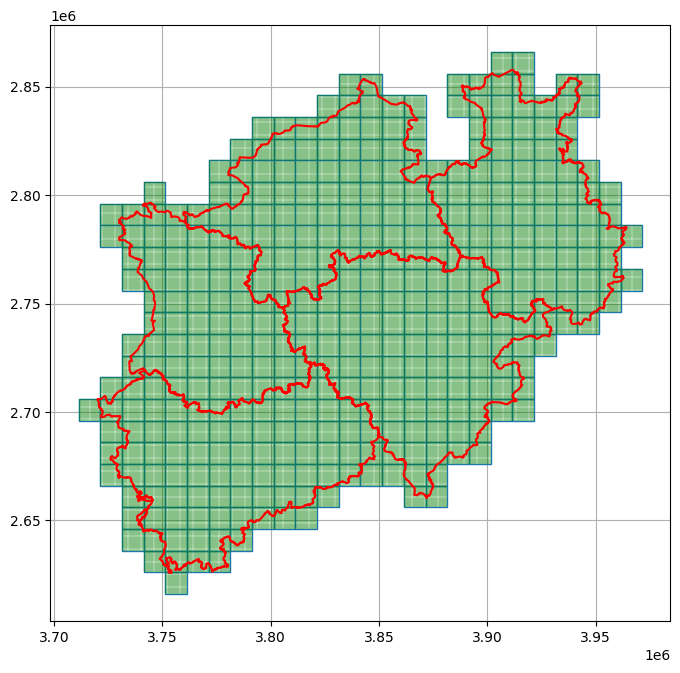

In [56]:
fig, ax = plt.subplots(1, figsize=(8,8))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=1)
mask_100m.boundary.plot(ax=ax, linewidth=0.1, color='green')
outline_nrw.boundary.plot(ax=ax, color='red')
plt.grid()
plt.savefig('../../images/fig_methods2.png', dpi=300)

## Calculating Heat Demand for every 10 km cell on a 100 m resolution

Now, we are calculating the heat demand for every global 10 km cell containing our 100 m cells. 

**NB: For the sake of demonstration, we are increasing the cell size to 500 m.**

### Loading the Heat Demand Input Data

The Heat Demand Input Data is downloaded from https://www.opengeodata.nrw.de/produkte/umwelt_klima/klima/raumwaermebedarfsmodell/. For faster processing, the GeoDataBase was converted to a ShapeFile, most of the columns were deleted and only every 100th `OBJECTID` polygon was selected. 

In [60]:
gdf_hd = gpd.read_file('../../../data/Raumwaermebadarfsmodell-NRW_filtered.shp')
gdf_hd

,OBJECTID,Fest_ID,spez_WB_HU,WB_HU,geometry
0,100.0,10000836,0.000000,0.000000,"POLYGON Z ((3859290.491 2682902.675 0.000, 385..."
1,200.0,10001905,0.000000,0.000000,"POLYGON Z ((3745839.940 2675413.675 0.000, 374..."
2,300.0,10002942,78.821478,13137.857506,"POLYGON Z ((3833217.083 2804641.151 0.000, 383..."
3,400.0,10003932,77.997000,2594.202309,"POLYGON Z ((3891474.005 2750914.998 0.000, 389..."
4,500.0,10004842,0.000000,0.000000,"POLYGON Z ((3838327.293 2831924.272 0.000, 383..."
...,...,...,...,...,...
110362,11036300.0,9167123,0.000000,0.000000,"POLYGON Z ((3757884.685 2773450.691 0.000, 375..."
110363,11036400.0,9167224,0.000000,0.000000,"POLYGON Z ((3780882.849 2758749.787 0.000, 378..."
110364,11036500.0,9167324,124.899122,16178.285166,"POLYGON Z ((3779201.571 2761661.284 0.000, 377..."
110365,11036600.0,9167424,0.000000,0.000000,"POLYGON Z ((3774150.137 2745190.630 0.000, 377..."


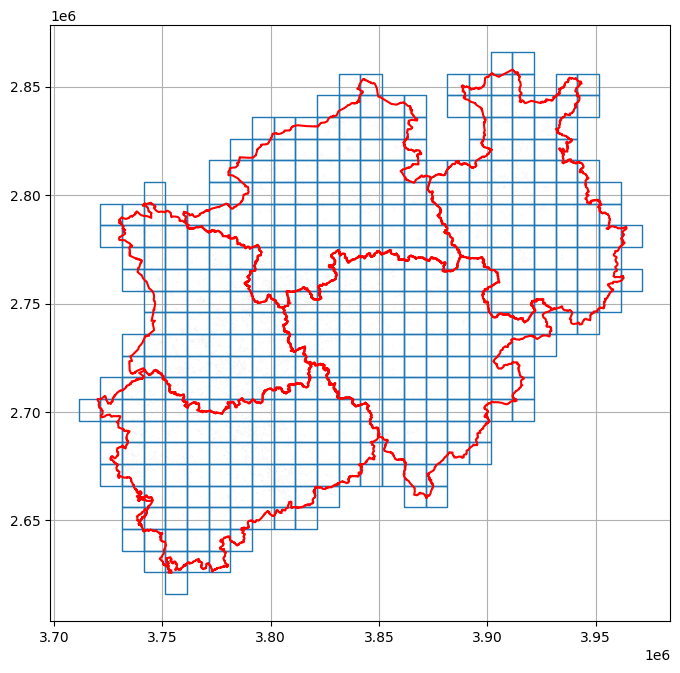

In [61]:
fig, ax = plt.subplots(1, figsize=(8,8))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=1)
# mask_100m.boundary.plot(ax=ax, linewidth=0.1, color='green')
outline_nrw.boundary.plot(ax=ax, color='red')
gdf_hd.plot(ax=ax)
plt.grid()

### Calculating Heat Demand for every mask

We are using list comprehension to iterate over each 10 km mask containing the 100 m (500 m) cells and calculate the heat demand. The DataFrames will be concatenated in the end for the final result. 

In [ ]:
heat_demand_list = [processing.calculate_hd(hd_gdf=gdf_hd, mask_gdf=mask_100m_cropped[i], hd_data_column='WB_HU') for i in tqdm(range(len(mask_100m_cropped)))]

In [70]:
heat_demand = pd.concat(heat_demand_list).reset_index(drop=True)
heat_demand.head()

,HD,geometry
0,0.000000,"POLYGON ((3720470.877 2702999.353, 3720970.877..."
1,0.000000,"POLYGON ((3720970.877 2701999.353, 3721470.877..."
2,0.000000,"POLYGON ((3720970.877 2702499.353, 3721470.877..."
3,34306.492104,"POLYGON ((3720970.877 2704499.353, 3721470.877..."
4,51040.742329,"POLYGON ((3728970.877 2674499.353, 3729470.877..."


In [89]:
heat_demand.to_file('../../../data/HD_NRW.shp')

In [2]:
heat_demand = gpd.read_file('../../../data/HD_NRW.shp')
heat_demand.head()

,HD,geometry
0,0.000000,"POLYGON ((3720470.877 2702999.353, 3720470.877..."
1,0.000000,"POLYGON ((3720970.877 2701999.353, 3720970.877..."
2,0.000000,"POLYGON ((3720970.877 2702499.353, 3720970.877..."
3,34306.492104,"POLYGON ((3720970.877 2704499.353, 3720970.877..."
4,51040.742329,"POLYGON ((3728970.877 2674499.353, 3728970.877..."


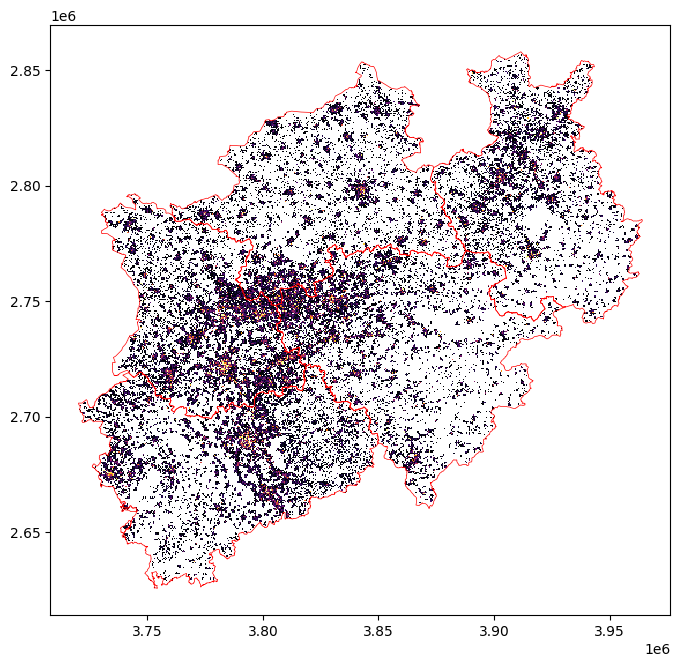

In [76]:
fig, ax = plt.subplots(1, figsize=(8,8))
# mask_10km_cropped.boundary.plot(ax=ax, linewidth=1, color='black')
# mask_100m.boundary.plot(ax=ax, linewidth=0.1, color='green')
outline_nrw.boundary.plot(ax=ax, color='red', linewidth=0.5)
heat_demand.plot(ax=ax, column='HD', cmap='inferno', vmax=5e5)
# plt.grid()
plt.savefig('../../images/fig_methods3.png', dpi=300)

## Rasterizing GeoDataFrame

In [5]:
processing.rasterize_gdf_hd(heat_demand, 
                     path_out='../../../data/HD_NRW2.tif',
                     crs = 'EPSG:3034', 
                     xsize = 500,
                     ysize = 500)

## Opening and plotting raster
The final raster can now be opened and plotted. 

In [35]:
raster = rasterio.open('../../../data/HD_NRW2.tif')

In [37]:
raster.bounds

BoundingBox(left=3720470.876781183, bottom=2857499.3533557905, right=3962970.876781183, top=2626499.3533557905)

In [39]:
raster_nodata = raster.nodata
raster = raster.read(1)
raster

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

In [40]:
raster[raster == raster_nodata] = np.nan

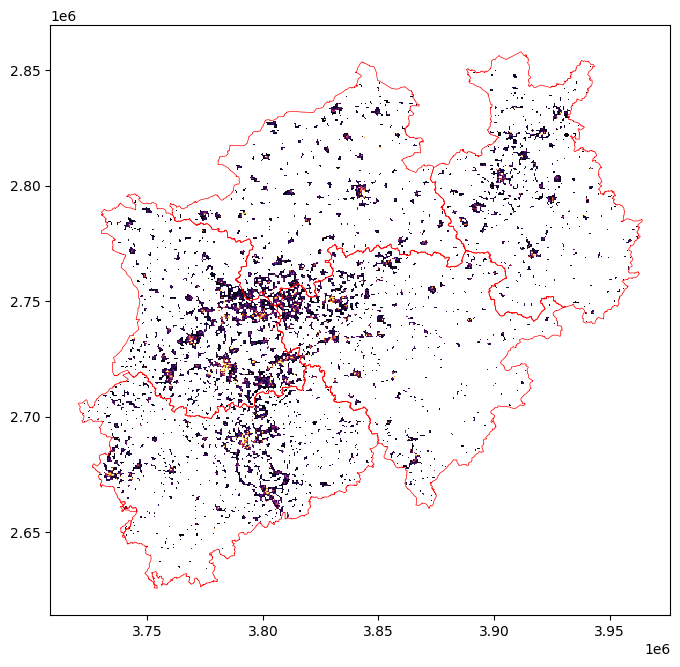

In [50]:
fig, ax = plt.subplots(1, figsize=(8,8))
plt.imshow(np.flipud(raster), vmax=5e5, cmap='inferno', extent=[3720470.876781183, 3962970.876781183,2626499.3533557905, 2857499.3533557905] )
outline_nrw.boundary.plot(ax=ax, color='red', linewidth=0.5)
plt.savefig('../../images/fig_methods4.png', dpi=300)